In [1]:
# ==== this should not be necessary - bug?
import sys

sys.path.append('/home/johannes/ldb/ldb_wlexecutor/src/ldb_wlexecutor/analysis/JOBExtended')
# ====

from helper import preprocess_runs

path_name_dict = {
    # 'job': 'imdb_scaled1/benchmark_optimum_runs/job_full_w_optimal.json',
    'JOB-Light': 'imdb_scaled1/benchmark_optimum_runs/job_light_w_optimal_w_idxs.json',
    'JOB': 'imdb_scaled1/benchmark_optimum_runs/job_full_w_optimal_w_idxs.json',
    # 'job_w_idxs_combined': 'imdb_scaled1/join_order_job_w_idxs_combined.json', # we only look at PG plans - hence better optimums are not necessary
    # 'job_extended_w_idxs': 'imdb_scaled1/benchmark_optimum_runs/job_extended_v20250426_w_optimal_w_idxs.json',
    # 'job_extended_w_idxs_combined': 'imdb_scaled1/join_order_JOBExtended_v20250426._combined.json', # we only look at PG plans - hence better optimums are not necessary
    # 'job_extended2_w_idxs': 'imdb_scaled1/benchmark_optimum_runs/job_extended_v20250509_w_optimal_w_idxs.json',
    'JOB-Extended': 'imdb_scaled1/JOBExtended_selection1.json'
}
benchmark_stats_dict = preprocess_runs(path_name_dict)

Loading run files from /mnt/c/PhD/ldb/ldb_data/runs/json
Benchmark: JOB-Light (140 plans)


Cleaning SQL: 100%|██████████| 140/140 [00:01<00:00, 91.75it/s]


Benchmark: JOB (226 plans)


Cleaning SQL: 100%|██████████| 226/226 [00:02<00:00, 86.39it/s]


Benchmark: JOB-Extended (15805 plans)


Cleaning SQL: 100%|██████████| 15805/15805 [00:00<00:00, 65711.73it/s]


# Card Est Accuracy Analysis

Benchmark       Num Queries    Avg Q-Error    Median Q-Error    90th Percentile Q-Error    95th Percentile Q-Error    Max Q-Error
------------  -------------  -------------  ----------------  -------------------------  -------------------------  -------------
JOB-Light                70        160.691           7.40122                    163.573                     814.13        3488.55
JOB                     113       3086.33          277.698                     5868                       14638.5        52306
JOB-Extended             30       9754.82          757.5                      18235                       66423         107652


Benchmark       Num Queries    Avg Q-Error    Median Q-Error    90th Percentile Q-Error    95th Percentile Q-Error    Max Q-Error
------------  -------------  -------------  ----------------  -------------------------  -------------------------  -------------
JOB-Light                70         1                      1                        1         

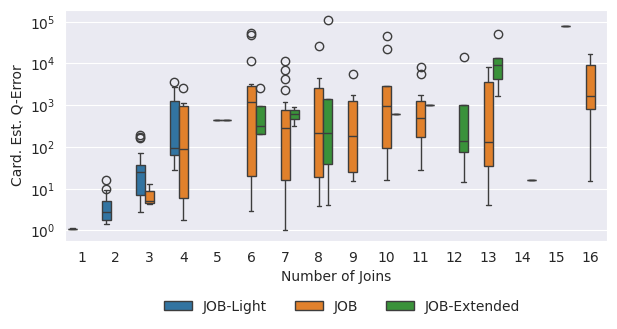

In [27]:
import pandas as pd
import numpy as np

opt_plan_card_qerrors = {}
pg_plan_card_qerrors = {}

df_list = []

# tabulate rows
pg_tabulate_rows = []
opt_tabulate_rows = []

card_error_vs_q_error = {}

for benchmark_name, info in benchmark_stats_dict.items():
    num_tables_list = []
    pgplan_act_card_list = []
    pgplan_est_card_list = []
    optplan_act_card_list = []
    optplan_est_card_list = []
    pg_cost = []
    pg_runtime = []
    pg_plan_qerror = []
    opt_plan_qerror = []

    for id, (sql, plan_info) in enumerate(info.items()):
        opt_rt = plan_info['opt_runtime']
        pg_rt = plan_info['pg_runtime']

        if opt_rt is None or pg_rt is None:
            print(f'Skip because of null: {opt_rt} / {pg_rt} / {sql}')
            continue

        num_tables_list.append(plan_info['num_tables'])

        # get postgres selected plan
        pgplan_act_card_list.append(plan_info['pg_plan_act_card_root'])
        pgplan_est_card_list.append(plan_info['pg_plan_est_card_root'])
        pg_plan_qerror.append(plan_info['pg_plan_card_error'])

        # get optimum selected plan
        optplan_act_card_list.append(plan_info['opt_plan_act_card_root'])
        optplan_est_card_list.append(plan_info['opt_plan_est_card_root'])
        opt_plan_qerror.append(plan_info['opt_plan_card_error'])

        pg_cost.append(plan_info['pg_plan_cost'])
        pg_runtime.append(pg_rt)

    # convert to df
    df = pd.DataFrame({
        'benchmark_name': [benchmark_name] * len(num_tables_list),
        'num_tables': num_tables_list,
        'pgplan_act_card': pgplan_act_card_list,
        'pgplan_est_card': pgplan_est_card_list,
        'optplan_act_card': optplan_act_card_list,
        'optplan_est_card': optplan_est_card_list,
        'pg_cost': pg_cost,
        'pg_runtime': pg_runtime,
        'pgplan_q_error': pg_plan_qerror,
        'optplan_q_error': opt_plan_qerror,
    })

    df['num_joins'] = df['num_tables'] - 1
    df_list.append(df)


    # compute avg q-error, median q-error, 95th percentile q-error
    def extract_stats(key: str):
        final_transformed = df[key][np.isfinite(df[key])]

        avg_q_error = np.mean(final_transformed)
        median_q_error = np.median(final_transformed)
        q_90th = np.percentile(final_transformed, 90)
        q_95th = np.percentile(final_transformed, 95)
        max_q_error = np.max(df[key])
        return avg_q_error, median_q_error, q_90th, q_95th, max_q_error


    opt_tabulate_rows.append([benchmark_name, len(info), *extract_stats('optplan_q_error')])
    pg_tabulate_rows.append([benchmark_name, len(info), *extract_stats('pgplan_q_error')])

# print tabulate rows
from tabulate import tabulate

print(tabulate(pg_tabulate_rows,
               headers=['Benchmark', 'Num Queries', 'Avg Q-Error', 'Median Q-Error', '90th Percentile Q-Error',
                        '95th Percentile Q-Error', 'Max Q-Error']))
print("\n")
print(tabulate(opt_tabulate_rows,
               headers=['Benchmark', 'Num Queries', 'Avg Q-Error', 'Median Q-Error', '90th Percentile Q-Error',
                        '95th Percentile Q-Error', 'Max Q-Error']))

import matplotlib.pyplot as plt
import seaborn as sns


def plot_boxplot(key='pgplan_q_error'):
    # concat dataframes
    df = pd.concat(df_list, ignore_index=True)

    # Plotting
    plt.figure(figsize=(7, 3))
    sns.boxplot(data=df, x='num_joins', y=key, hue='benchmark_name', showmeans=False, showfliers=True)

    # Customize plot
    # plt.title('Postgres Cardinality Estimates Boxplot')
    plt.xlabel('Number of Joins')
    plt.ylabel('Card. Est. Q-Error')
    plt.legend(frameon=False, ncol=3, loc='upper left', bbox_to_anchor=(0.16, -0.2))

    # add logscale on y-axis
    plt.yscale('log')
    plt.savefig('/mnt/c/Users/Johannes/Downloads/card_est_boxplot.pdf', bbox_inches='tight', dpi=300, transparent=False)


plot_boxplot(key='pgplan_q_error')
# plot_boxplot(key='optplan_q_error') # we have supplied pg with actual cards - info not meaningful here

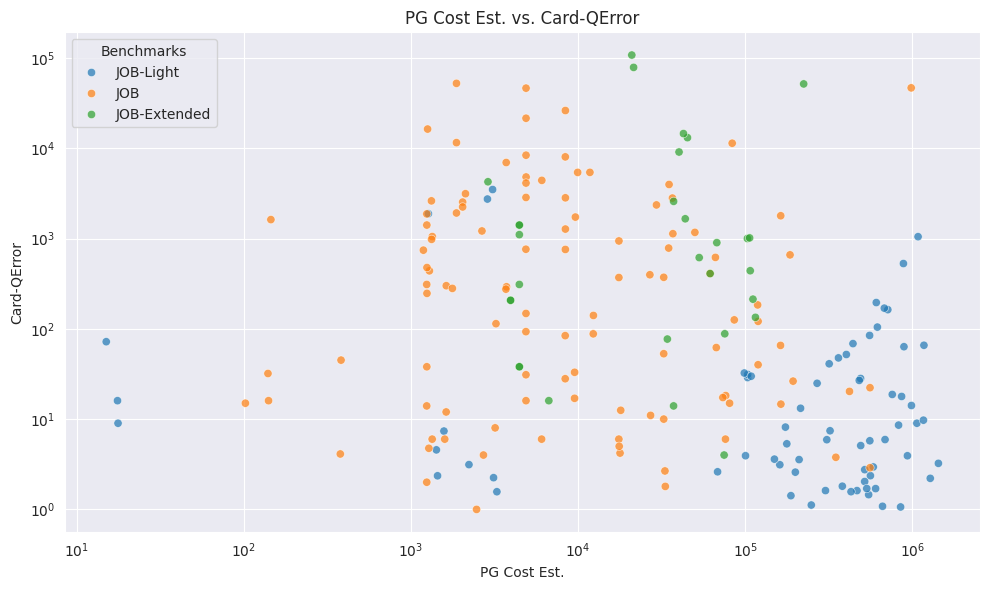

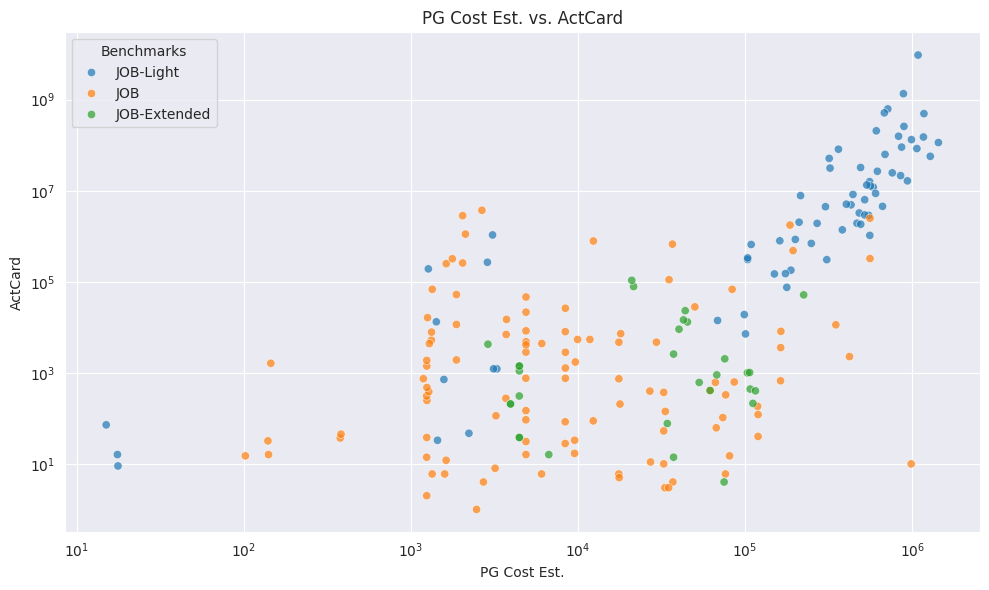

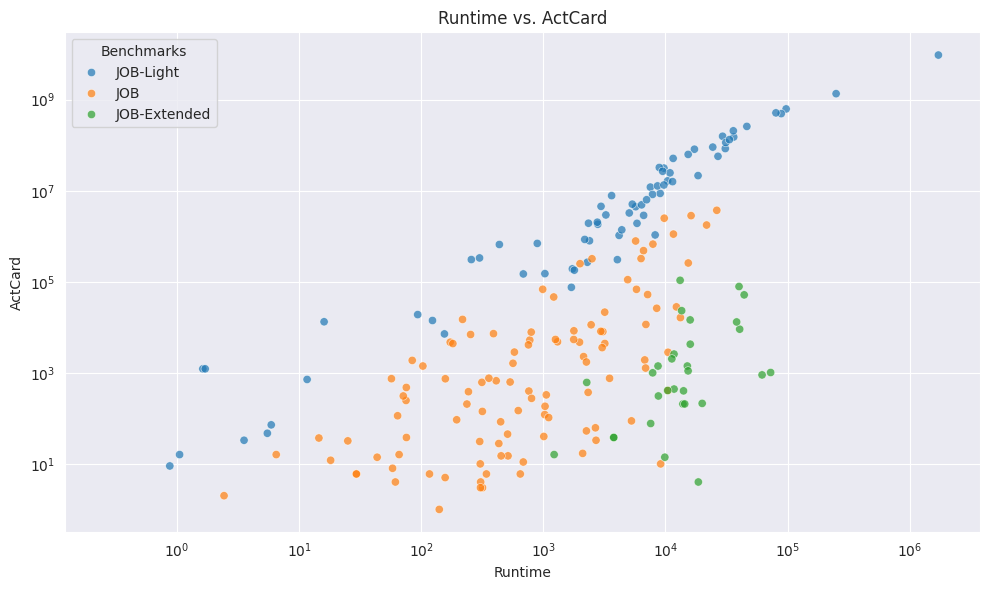

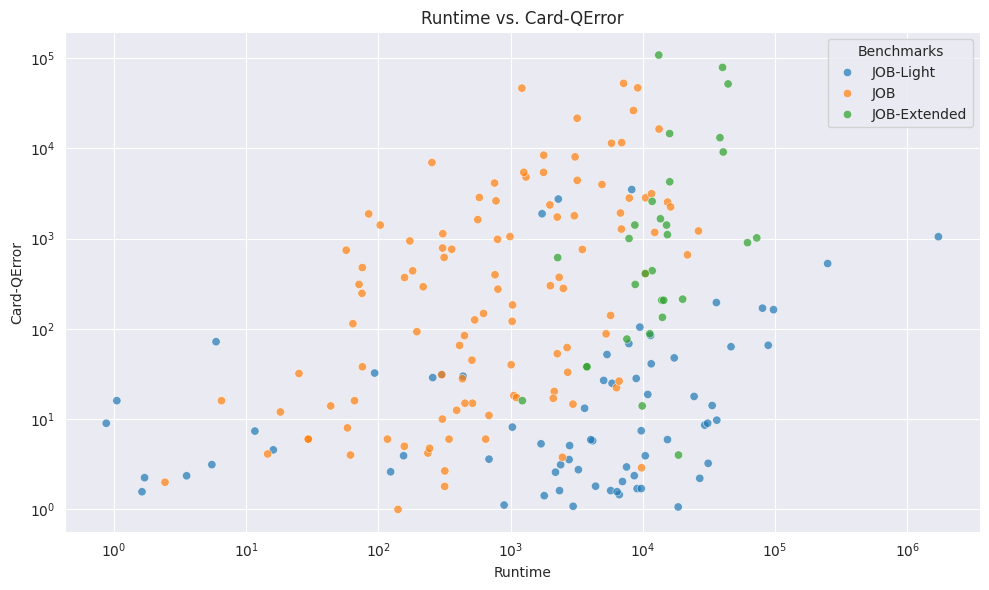

In [3]:
# create scatter plot pg_cost vs. pgplan_q_error
def plot_scatter_pg_cost_vs_q_error(xkey='pg_cost', xlabel='PG Cost Est.', ykey='pgplan_q_error', ylabel='Card-QError'):
    # concat dataframes
    df = pd.concat(df_list, ignore_index=True)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=xkey, y=ykey, hue='benchmark_name', alpha=0.7)

    # Customize plot
    plt.title(f'{xlabel} vs. {ylabel}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title='Benchmarks')

    # add logscale on y-axis
    plt.xscale('log')
    plt.yscale('log')

    plt.tight_layout()
    plt.show()


plot_scatter_pg_cost_vs_q_error()
plot_scatter_pg_cost_vs_q_error(ykey='pgplan_act_card', ylabel='ActCard')
plot_scatter_pg_cost_vs_q_error(ykey='pgplan_act_card', ylabel='ActCard', xkey='pg_runtime', xlabel='Runtime')
plot_scatter_pg_cost_vs_q_error(xkey='pg_runtime', xlabel='Runtime')

In [4]:
mismatches_list = []
mismatches_plans = []
key = 'job_extended_w_idxs'
for sql, plan_info in benchmark_stats_dict[key].items():
    opt_plan = plan_info['opt_plan']
    act_card = plan_info['opt_plan_act_card_root']
    est_card = plan_info['opt_plan_est_card_root']

    if act_card != est_card:
        mismatches_list.append([act_card, est_card])
        mismatches_plans.append([opt_plan, sql, plan_info['opt_hint']])

print(f'Num Mismatches: {len(mismatches_list)} / {len(benchmark_stats_dict[key])}')

KeyError: 'job_extended_w_idxs'

In [5]:
pd.DataFrame(mismatches_list, columns=['Actual Card', 'Estimated Card'])

,Actual Card,Estimated Card
0,8304,33
1,12051020,315696
2,17003939,206
3,115709,787
4,2896165,303760
5,431897,331
6,605,64


In [6]:
import json

key = 0
print(mismatches_list[key])

print(f'SQL: {mismatches_plans[key][1]}')
print(f'Hint: {mismatches_plans[key][2]}')
print(json.dumps(mismatches_plans[key][0], indent=4))

[8304, 33]
SQL: SELECT MIN(n.name) AS member_in_charnamed_movie FROM cast_info AS ci, company_name AS cn, keyword AS k, movie_companies AS mc, movie_keyword AS mk, name AS n, title AS t, char_name AS cn2, aka_name AS ak WHERE cn.country_code ='[us]' AND k.keyword ='character-name-in-title' AND n.id = ci.person_id AND ci.movie_id = t.id AND t.id = mk.movie_id AND mk.keyword_id = k.id AND t.id = mc.movie_id AND mc.company_id = cn.id AND ci.movie_id = mc.movie_id AND ci.movie_id = mk.movie_id AND mc.movie_id = mk.movie_id AND ak.name_pcode_cf = cn2.name_pcode_nf AND ak.name_pcode_nf = n.name_pcode_cf AND ak.name_pcode_nf = cn2.surname_pcode AND ak.name_pcode_cf = cn.name_pcode_sf AND cn.name_pcode_nf = n.name_pcode_nf;
Hint: /*+ Rows(ak cn2 #366551) Rows(ci mc #80274241) Rows(mc t #2609129) Rows(ak n #628033002) Rows(cn n #41866109) Rows(cn mc #1153798) Rows(ci mk #215765477) Rows(cn cn2 #31319451) Rows(mc mk #34863638) Rows(ak cn #8962153) Rows(ci n #36244344) Rows(cn2 n #1852237544) Row